#### Set up project and environment

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

In [3]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [4]:
train_path = "../data/raw/train.csv"
test_path = "../data/raw/test.csv"

In [5]:
train_df = pd.read_csv(train_path) 
test_df = pd.read_csv(test_path) 

#### Basic dataset understanding

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df.shape

(7613, 5)

In [10]:
train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   id        7613 non-null   int64
 1   keyword   7552 non-null   str  
 2   location  5080 non-null   str  
 3   text      7613 non-null   str  
 4   target    7613 non-null   int64
dtypes: int64(2), str(3)
memory usage: 297.5 KB


In [11]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train_df['target'].value_counts(normalize=True).round(3)

target
0    57.0
1    43.0
Name: proportion, dtype: float64

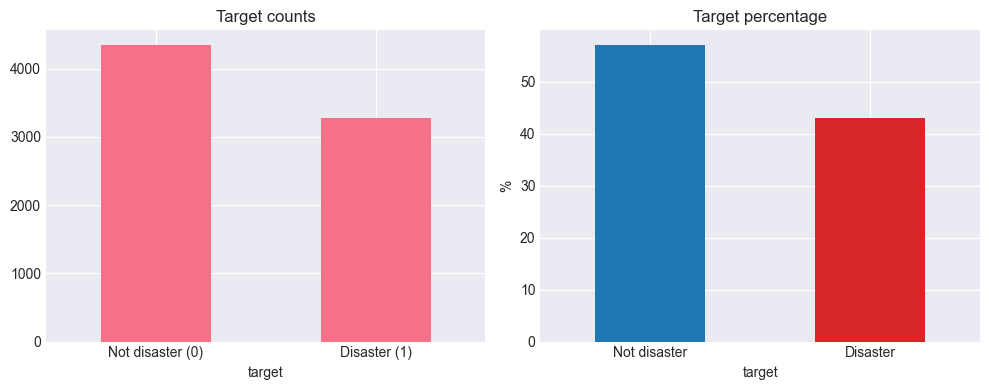

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

train_df['target'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_xticklabels(["Not disaster (0)", "Disaster (1)"], rotation=0)
ax[0].set_title("Target counts")

train_df["target"].value_counts(normalize=True).mul(100).plot(
    kind="bar", ax=ax[1], color=["tab:blue","tab:red"]
)
ax[1].set_xticklabels(["Not disaster", "Disaster"], rotation=0)
ax[1].set_ylabel("%")
ax[1].set_title("Target percentage")

plt.tight_layout()
plt.show()

#### Text length and word count analysis

In [26]:
train_df['char_len'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

train_df.groupby('target')[['char_len','word_count']].describe()

char_len                                                          \
          count        mean        std   min   25%    50%    75%    max   
target                                                                    
0        4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0   
1        3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0   

       word_count                                                    
            count       mean       std  min   25%   50%   75%   max  
target                                                               
0          4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0  
1          3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0

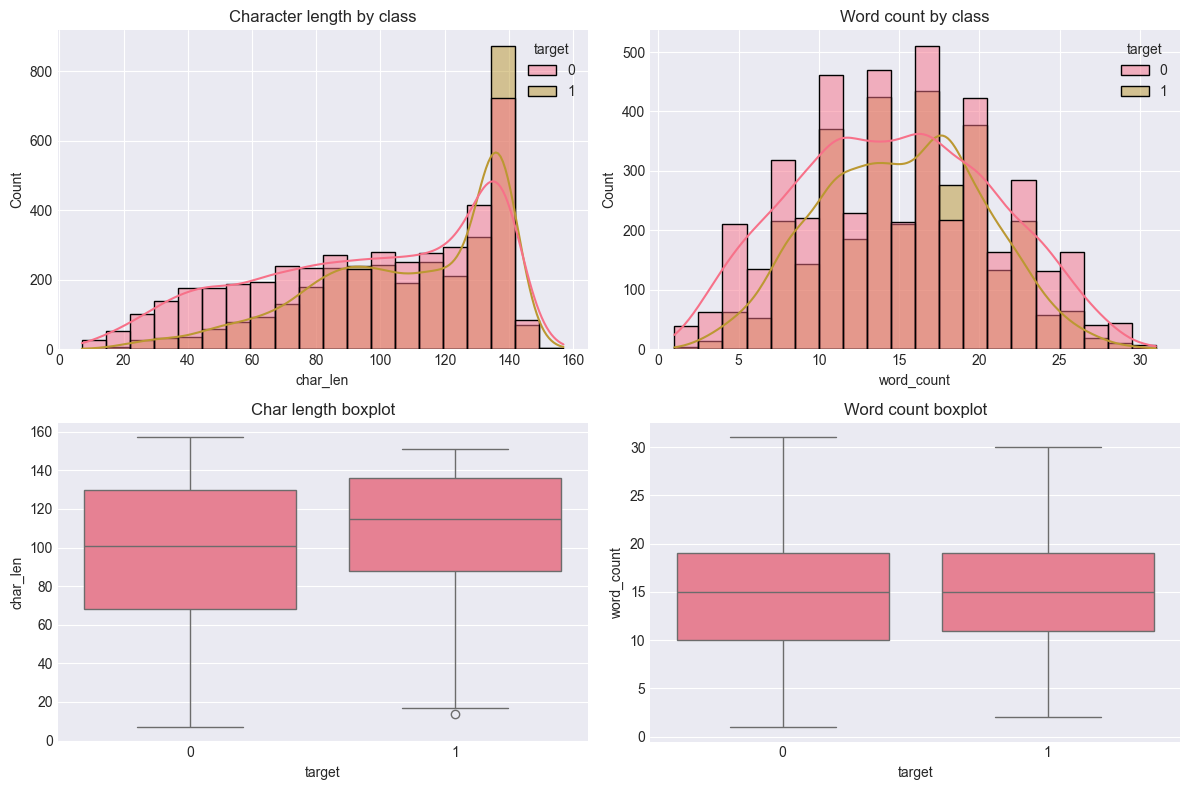

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.histplot(
    data=train_df, x="char_len", hue="target",
    bins=20, kde=True, ax=axes[0,0]
)
axes[0,0].set_title("Character length by class")

sns.histplot(data=train_df, x='word_count',hue='target',bins=20, kde='True', ax=axes[0,1])
axes[0,1].set_title("Word count by class")

sns.boxplot(
    data=train_df, x="target", y="char_len", ax=axes[1,0]
)
axes[1,0].set_title("Char length boxplot")

sns.boxplot(
    data=train_df, x="target", y="word_count", ax=axes[1,1]
)
axes[1,1].set_title("Word count boxplot")

plt.tight_layout()
plt.show()

#### Keyword and location exploration

In [43]:
print("Unique keywords:", train_df["keyword"].nunique())
print("Missing keywords:", train_df["keyword"].isna().sum())

print("Unique locations:", train_df["location"].nunique())
print("Missing locations:", train_df["location"].isna().sum())

Unique keywords: 221
Missing keywords: 61
Unique locations: 3341
Missing locations: 2533


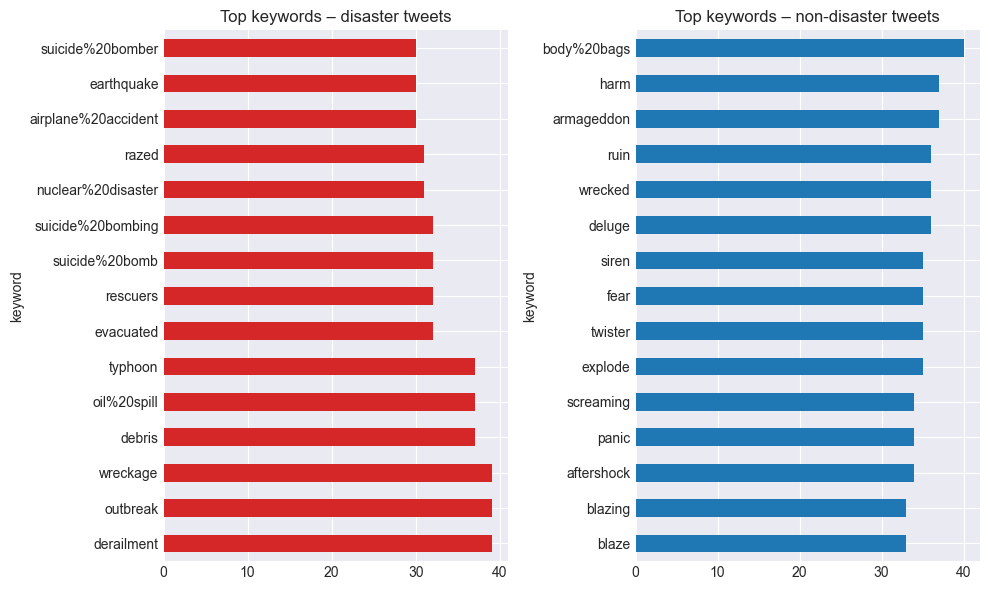

In [56]:
disaster_keywords = train_df[train_df['target'] == 1]['keyword'].value_counts().head(15)
No_disaster_keywords = train_df[train_df['target'] == 0]['keyword'].value_counts().head(15)

fig, axes = plt.subplots(1,2 , figsize=(10,6))

disaster_keywords.plot(kind='barh',ax=axes[0], color="tab:red")

axes[0].set_title("Top keywords – disaster tweets")

No_disaster_keywords.sort_values().plot(kind="barh", ax=axes[1], color="tab:blue")
axes[1].set_title("Top keywords – non-disaster tweets")

plt.tight_layout()
plt.show()

#### Word clouds for each class

In [60]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keval\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

#### Top words per class (after simple cleaning)

In [67]:
def clean_basic(text):
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'@\\w+', '', text)
    text = re.sub(r'[^A-Za-z\\s]', ' ', text)
    text = text.lower()
    return text

def top_words(series, n=20):
    all_words = []
    for t in series:
        t = clean_basic(str(t))
        for w in t.split():
            if w not in stop_words and len(w) > 2:
                all_words.append(w)
    return Counter(all_words).most_common(n)

In [74]:
top_disaster = top_words(train_df[train_df["target"]==1]["text"])
top_nondisaster = top_words(train_df[train_df["target"]==0]["text"])

top_disaster_df = pd.DataFrame(top_disaster, columns=["word","count"])
top_nondisaster_df = pd.DataFrame(top_nondisaster, columns=["word","count"])

C:\Users\keval\AppData\Local\Temp\ipykernel_10944\3725255036.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top_disaster_df['word'], rotation=90)
C:\Users\keval\AppData\Local\Temp\ipykernel_10944\3725255036.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(top_nondisaster_df['word'], rotation=90)


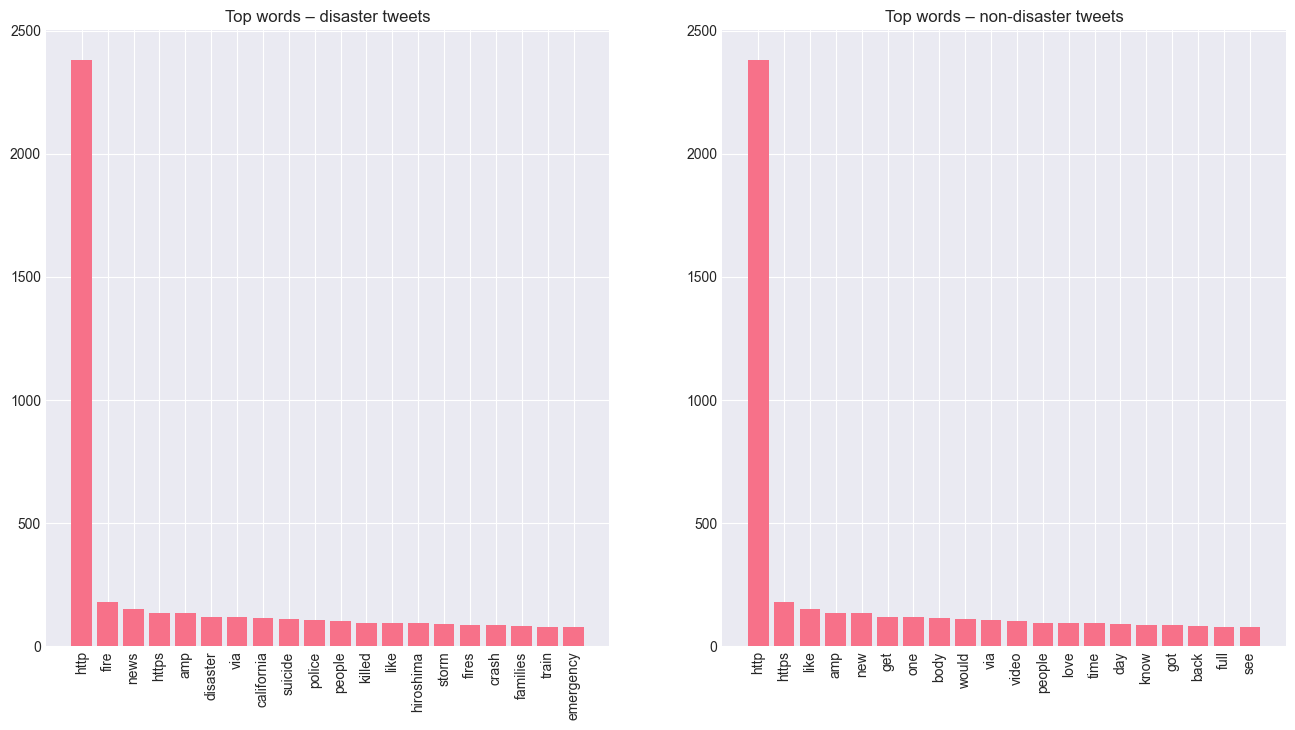

In [90]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].bar(top_disaster_df['word'], top_disaster_df['count'])
axes[0].set_xticklabels(top_disaster_df['word'], rotation=90)
axes[0].set_title("Top words – disaster tweets")

axes[1].bar(top_nondisaster_df['word'], top_disaster_df['count'])
axes[1].set_xticklabels(top_nondisaster_df['word'], rotation=90)
axes[1].set_title("Top words – non-disaster tweets")

plt.show()

#### Look at concrete examples

In [91]:
print("=== Sample DISASTER tweets ===")
for t in train_df[train_df["target"]==1]["text"].head(10):
    print("-", t)

print("\n=== Sample NON-DISASTER tweets ===")
for t in train_df[train_df["target"]==0]["text"].head(10):
    print("-", t)


=== Sample DISASTER tweets ===
- Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
- Forest fire near La Ronge Sask. Canada
- All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
- 13,000 people receive #wildfires evacuation orders in California 
- Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
- #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
- #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
- I'm on top of the hill and I can see a fire in the woods...
- There's an emergency evacuation happening now in the building across the street
- I'm afraid that the tornado is coming to our area...

=== Sample NON-DISASTER tweets ===
- What's up man?
- I love fruits
- Summer is lovely
- My car is so fast
- What a goooooooaaaaaal!!!!!!
- this is ri

#### End-of-Week-1 summary

1. What patterns do you see in disaster vs non-disaster tweets?
   There is clean theft, fear and likewise keywords in disaster tweets, whereas non-disaster tweets are normal once.

2. Are there obvious keywords that signal disasters?
   Yes, there are many obviouse keywords that signal disaster like suicide, accident, plain accident etc.

3. Are lengths/word counts different?
   There is not major difference in length of char or word, only minor difference.

4. What challenges do you foresee? (sarcasm, metaphors, short tweets, etc.)
    Some potential challenges include:
    - Sarcasm or irony, which can invert the apparent meaning of a tweet.
    - Use of metaphors, slang, or coded language that makes disaster context ambiguous.
    - Very short tweets lacking enough context for classification.
    - Ambiguity in tweets where keywords are used with non-disaster meanings.
    - Misspellings, creative spelling, or abbreviations that make keywords harder to detect.
    - Noise from retweets, hashtags, or automated posts.
    - Lack of sufficient labeled data for rare disaster types.